In [1]:
import os
import re
import pickle  # 保存模块
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from scipy.spatial import cKDTree
from sklearn.svm import SVR

import geopandas as gpd 
import operator 
import matplotlib.pyplot as plt
from sklearn import datasets
from ReclassifyLandUse import ReC
import NFIP_calculator
from NFIP_calculator import Insurer

import importlib
import DamageEstimation
importlib.reload( DamageEstimation )
from DamageEstimation import DepthDamage
import math
import contextily as ctx
from matplotlib.colors import rgb2hex

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
import time
from geo_northarrow import add_north_arrow
from pyogrio import read_dataframe, write_dataframe
import warnings
import seaborn as sns
import scipy.stats as stats
warnings.filterwarnings('ignore')


In [3]:
def floodh_adjust( probi , floodx, lgwaterdist ):
    if probi >= 0.1:
        return 0.505721 + 0.271128 * floodx - 0.07561 * lgwaterdist
    elif probi < 0.1 and probi >= 0.04:
        return 1.882091 + 0.814026 * floodx - 0.17498  * lgwaterdist
    elif probi < 0.04 and probi >= 0.02:
        return 5.392617 + 0.924160 * floodx - 0.428017 * lgwaterdist
    elif probi < 0.02 and probi >= 0.01:
        return 8.518673 + 0.883055 * floodx - 0.567981 * lgwaterdist
    else:
        return 11.73178 + 0.759123 * floodx - 0.624486 * lgwaterdist



def floodh_catediff( floodx, cate_diffs, probi ):
    if probi >= 0.1:
        return floodx + cate_diffs[0]
    elif probi < 0.1 and probi >= 0.04:
        return floodx + cate_diffs[1]
    elif probi < 0.04 and probi >= 0.02:
        return floodx + cate_diffs[2]
    elif probi < 0.02 and probi >= 0.01:
        return floodx + cate_diffs[3]
    else:
        return floodx + cate_diffs[4]

def dem_waterdist( delta_dem ):
    waterdist = 49.7718 * delta_dem
    return waterdist

print( floodh_adjust(0.9, 1.382017, 5.00987403) )

0.5016279297677


In [4]:
dictpth    = r'../inputs/saved_neighbor_dict.pkl'
with open( dictpth, 'rb' ) as f:
    GeoNeighbors = pickle.load(f)
def neghbor_prob( indx, Geodata, luc_col_name):
    #print( indx )
    nni = len( GeoNeighbors[ indx ]  )
    neighbor_probs = np.zeros( 5 ) 
    if nni > 0:
        subframei = Geodata[ Geodata['index'].isin( GeoNeighbors[indx]  ) ]
        sub_landuse_count = subframei[[luc_col_name]].value_counts()
        #print( sub_landuse_count )
        if 1 in sub_landuse_count:
            neighbor_probs[0] = sub_landuse_count[1] * 1.0 / nni
        if 2 in sub_landuse_count:
            neighbor_probs[1] = sub_landuse_count[2] * 1.0 / nni
        if 3 in sub_landuse_count:
            neighbor_probs[2] = sub_landuse_count[3] * 1.0 / nni
        if 4 in sub_landuse_count:
            neighbor_probs[3] = sub_landuse_count[4] * 1.0 / nni
        if 5 in sub_landuse_count:
            neighbor_probs[4] = sub_landuse_count[5] * 1.0 / nni
    return np.max(  neighbor_probs ), np.argmax(  neighbor_probs )



In [38]:

fp = "../inputs/gis_data/Parcel_input_sce1.shp"
Geodata = read_dataframe(fp)
Geodata = Geodata.to_crs({'init':'epsg:4326'})

In [40]:
# slrsces   =  [ 0.000003, 0.000033, 0.000103, 0.000183, 0.000183 ]
predYrs             = 2020
deltaY              = 2
initialYrs          = 2010
Geodata.sort_values("TARGET_FID", ascending = True, inplace = True)
Geodata["LUC20"]      = Geodata['LUCode11re']
Geodata_dict = Geodata.to_dict('records')
def_value = 0
damage_count_dict2 = dict.fromkeys( Geodata.TARGET_FID.to_list() ,def_value)
damage_perct_dict2 = dict.fromkeys( Geodata.TARGET_FID.to_list() ,def_value)

ResidentialGrowth = (np.sum( Geodata.loc[ (Geodata["LUCode20re"] > 0) & 
                                         (Geodata["LUCode20re"] < 6), "pararea" ]) - 
                     np.sum( Geodata.loc[ (Geodata["LUCode11re"] > 0) & 
                                         (Geodata["LUCode11re"] < 6), "pararea" ]) )

print(ResidentialGrowth)
#ResidentialGrowth = 39883108.19182694
predyears = range(initialYrs, predYrs, deltaY)
print( len(predyears) )
LandGrowth        = np.round( ResidentialGrowth ) * deltaY / 10
print(LandGrowth)
Geodata['LANDUSE'] = Geodata['LANDUSE'].fillna('')
growth_agg          = deltaY
Geodata_dict = Geodata.to_dict('records')

rand_unif = stats.uniform.rvs(loc= 0, scale= 1, 
                              size= ( 1, len(predyears) ) )

Aggregate_Year                  = pd.DataFrame()
Aggregate_Year["Year"]          = predyears
aggregate_damage_dict2 = dict.fromkeys( Aggregate_Year.Year.to_list() ,def_value)


57174649.62915
5
11434930.0


In [23]:
list(predyears)

[2010, 2012, 2014, 2016, 2018]

In [41]:
ncolumns    = len( rand_unif[0] )
nrows       = len( rand_unif )
total_parcel_N = len( Geodata )
improvedValues  = np.zeros( total_parcel_N ) 
changes         = np.zeros( total_parcel_N ) 
impvi_b0 = np.random.normal(159961.40, 2543.65, size = total_parcel_N)
impvi_b1 = np.random.normal(158.84, 55.61, size = total_parcel_N)
for i in range( nrows  ):
    slrH   = 0
    para_b = 0.000003
    for yith in range( ncolumns ):
        #heighti  = rand_heights[i, yith] #feet
        #probi    = rand_unif[i, yith]
        yeark    = predyears[ yith ]
        """" update probs from gbdt"""
        totalDamage_i     = 0
        if ( yeark % growth_agg == 0) :
            LandGrowth_agg        = np.round( LandGrowth ) 
            print("********Before*******")
            print( Geodata.loc[( Geodata["LUCode11re"] > 0 ) & (Geodata["LUCode11re"] < 6)].pararea.sum()  )
            print( Geodata.loc[( Geodata["LUC20"] > 0 ) & (Geodata["LUC20"] < 6)].pararea.sum(), " ", LandGrowth_agg  )
            landuseProb       = np.zeros( total_parcel_N ) 
            landuselist       = np.zeros( total_parcel_N ) 
            NeighbiorLU       = np.zeros( total_parcel_N ) 
            landuseType       = np.zeros( total_parcel_N ) 
        idx_parcel        =  0
        Geodata_dict  = Geodata.to_dict('records')
        for rowi in Geodata_dict:
            if ( yeark % growth_agg == 0) :
                #print( "Year ",yith  )
                if rowi['LUC20']   <= 5 and rowi['LUC20'] > 0 and rowi['VAL19IMP'] > 0:
                    landuseProb[ idx_parcel]      +=  -1.0
                    landuseType[ idx_parcel]       =  rowi['LUC20'] 
                    improvedValues[ idx_parcel]    =  rowi['VAL19IMP']
                    #if rowi['LUC2'] > 0 and rowi['LUC2'] < 5:
                    #    print("??? LU developed ", rowi['LUC2'], row['VAL19IMP'], row['LANDUSE'])
                elif (rowi['poicode'] == 2204 or rowi['poicode'] == 2082 or 
                        rowi['poicode'] == 2081) :
                    landuseProb[ idx_parcel]       = 0.0
                    landuseType[ idx_parcel]       = rowi['LUCode11re']  
                    improvedValues[ idx_parcel]    = rowi['VAL19IMP'] 
                elif rowi['parkigcode'] > 0 or rowi['watercode'] > 0 :
                    landuseProb[ idx_parcel]       = 0.0 
                    improvedValues[ idx_parcel]    = rowi['VAL19IMP']
                    landuseType[ idx_parcel]       =  rowi['LUC20'] 
                elif rowi['LUC20']   != rowi['LUCode11re'] :
                    landuseProb[idx_parcel]       +=  -1.0 
                    landuseType[ idx_parcel]       =  rowi['LUC20'] 
                    improvedValues[ idx_parcel]    =  rowi['VAL19IMP']    
                else:
                    urban_neighbor_probs = neghbor_prob( rowi['TARGET_FID'], Geodata, 'LUC20')
                    maxlu         = rowi['predLU']
                    if maxlu == urban_neighbor_probs[1]+ 1 and maxlu == rowi['LUCode'] :
                        landuseType[ idx_parcel]  =  maxlu
                        landuseProb[ idx_parcel]  = rowi['predprobs']
                    elif urban_neighbor_probs[1] + 1 ==  rowi['LUCode']:
                        landuseType[ idx_parcel]  =  urban_neighbor_probs[1] + 1
                        landuseProb[ idx_parcel]  = urban_neighbor_probs[0]
                    else:
                        landuseType[ idx_parcel]  = maxlu
                        landuseProb[ idx_parcel]  = rowi['predprobs']              
                    improvedValues[ idx_parcel]   =  rowi['VAL19IMP']  
                #landuselist[ idx_parcel ] = rowi['LUC2']  
            idx_parcel = idx_parcel + 1
        if ( yeark  % growth_agg == 0) :
            Geodata["LUCprob"]  = landuseProb
            Geodata["LUCtype"]  = landuseType
            Geodata["ImproVal"] = improvedValues    
            #Geodata["LUC2"]     = landuselist
            Geodata.sort_values("LUCprob", ascending = False, inplace = True)
            Geodata["rank"]     = Geodata.reset_index().index + 1
            Geodata["PAreaCum"] = Geodata["pararea"].cumsum()
            lengthi             = Geodata["PAreaCum"].searchsorted( LandGrowth_agg, side='right') + 1
            print( "length of pararea", lengthi )
            temnlu              = len( Geodata.loc[( Geodata["LUC20"] > 0 ) & (Geodata["LUC20"] < 6)] )
            Geodata_dict2  = Geodata.to_dict('records')
            count_rank = 0
            #for idx2 , rowi2 in Geodata.iterrows():
            for rowi2 in Geodata.itertuples():
                if count_rank < lengthi:
                    #print( rowi2.predprobs, " ", rowi2.LUC2 )
                    Geodata.at[ rowi2.Index, 'LUC20' ] = rowi2.LUCtype 
                    if rowi2.LUC20 <= 5 and rowi2.LUC20 >= 1 and rowi2.ImproVal == 0:
                        impvi = impvi_b0[ count_rank ]  + impvi_b1[ count_rank ]  * rowi2.pararea  
                        #print("urban land use value 0 ", rowi2['LUC2'])   
                        Geodata.at[ rowi2.Index, 'VAL19IMP' ] = impvi
                    else:
                        Geodata.at[ rowi2.Index, 'VAL19IMP' ] = rowi2.ImproVal
                    if rowi2.Index != rowi2.index:
                        print( Geodata.at[ rowi2.Index, 'index' ], "Error" )
                count_rank = count_rank + 1 
            print("********After*******")
            print( yeark, "# parcels diff ", len( Geodata.loc[( Geodata["LUC20"] > 0 ) & (Geodata["LUC20"] < 6)] ) - temnlu )
            Geodata.sort_values("TARGET_FID", ascending = True, inplace = True)
        #aggregate_damage_dict2[ yeark ] = aggregate_damage_dict[ yeark ] + totalDamage_i
print( Geodata.loc[( Geodata["LUCode11re"] > 0 ) & (Geodata["LUCode11re"] < 6)].pararea.sum()  )
print( Geodata.loc[( Geodata["LUC20"] > 0 ) & (Geodata["LUC20"] < 6)].pararea.sum(), " ", LandGrowth_agg  )


********Before*******
200394041.22387788
200394041.22387788   11434930.0
length of pararea 1549
********After*******
2010 # parcels diff  378
********Before*******
200394041.22387788
202531626.09442788   11434930.0
length of pararea 1870
********After*******
2012 # parcels diff  1326
********Before*******
200394041.22387788
211290744.2244279   11434930.0
length of pararea 5533
********After*******
2014 # parcels diff  3622
********Before*******
200394041.22387788
220394441.43512788   11434930.0
length of pararea 9304
********After*******
2016 # parcels diff  6119
********Before*******
200394041.22387788
228838274.14445788   11434930.0
length of pararea 8709
********After*******
2018 # parcels diff  5718
200394041.22387788
237411684.1986579   11434930.0


In [37]:
rowi2

Pandas(Index=170193, index=170193, TARGET_FID=170193, VAL19TOT=541630, VAL19LAND=301490.0, VAL19IMP=240140.0, LANDUSE='CL', landCode='Commercial', LUCode=2, poicode=0, poiclass=None, poiname=None, watercode=0, waterclass=None, watername=None, parkigcode=0, parkigclas=None, LUCode01re=2, LUCode06re=2, LUCode11re=2, LUCode15re=2, LUCode20re=2, ZipCode=77590, policyCost=22151792.0, policyCoun=43863.0, elevationN=1052.0, Content_Bu=0.509275171972515, ACRES=1.686, Cate1=99.0, Cate2=99.0, Cate3=99.0, Cate4=99.0, Cate5=99.0, NumStories=1, Foundation=100, FirstFloor=4.628837950688, ContentCos=275838.71139547357, BldgDamage=213, CDDF_ID=29, YEARBUILT=0, Tract='481677220021', Insurance=3361.96, PopTot=1291, TotalUnit=571, Mobile=0, vacant=37, MedHHInc=54871.0, TotAge65=263, BelowHigh=102, BelPoverty=126, Minority=0, PopWhite=1117, DEM=7.19856, BeachDist=13028.1516994, HealthDist=18184.985767, ParkDist=1904.93413065, SchoolDist=2411.49433246, CoastDist=11985.3192504, WetlatDist=4043.00811497, flo

In [42]:

color_mapping = { 0: "aqua", 1: "gold", 2: "firebrick",
                  3: "pink", 4: "mediumorchid", 5: "orange", 
                  6: "darkgreen", 7 : "limegreen"}


label_mapping = { 0: "Retired residential land", 1: "residential land",
                  2: "commercial land", 3: "industrial land", 
                  4: "infrastructural land", 5: "public land",
                  6: "green land", 7 : "open space"}

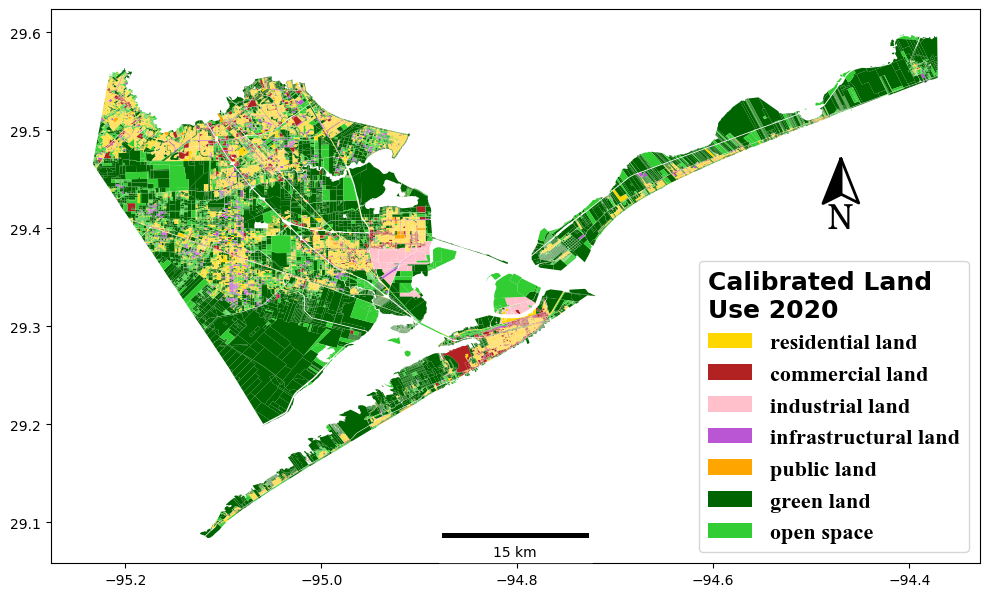

In [45]:
#fp = "../inputs/gis_data/Parcel_output_sce2.shp"
##Geodata = gpd.read_file(fp)
#read_start          = time.process_time()
#Geodata             = read_dataframe( fp )
#read_end            = time.process_time()
#Geodata      = Geodata.to_crs({'init':'epsg:4326'})

fig, ax = plt.subplots( figsize=(10, 8) )
pmarks = []
for ctype, data in Geodata.groupby('LUC20'):
    # Define the color for each group using the dictionary
    color = color_mapping[ctype]
    labeli = label_mapping[ctype]
    # Plot each group using the color defined above
    data.to_crs('EPSG:4326').plot(color=color, label= labeli ,
              ax = ax, linewidth=.01,
              markersize = 20, legend=True)
    #cx.add_basemap(plotx)
    pmarks.append(Patch(facecolor=color, label=labeli))

#ax.add_artist(scale2)
#ax.add_artist(ScaleBar(1, dimension="imperial-length", units="km"))
handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles=[ *handles,*pmarks ],
            title="Calibrated Land Use 2020",
            title_fontsize='xx-large', 
            loc='lower right',
            fontsize= 14,
            frameon=True )
leg._legend_box.align = "left"

legend = ax.get_legend()
legend.set_title( "Calibrated Land\nUse 2020" , prop={'size' : 18, 'weight':'bold'})
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()
#src_basemap = cx.providers.Stamen.Terrain
#cx.add_basemap( ax, source=src_basemap)
#cx.add_basemap(ax)

plt.tight_layout()
#plt.savefig('../output_images/LandUse_test2_2.png',dpi= 900, bbox_inches='tight', pad_inches=0)
plt.savefig('../output_images/LandUse_calibrated_2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
Geodata_select = gpd.GeoDataFrame( Geodata , geometry = 'geometry', crs="EPSG:4326")
write_dataframe(Geodata_select, 
                path= r'../inputs/gis_data/Parcel_output_sce2.shp',
                driver='ESRI Shapefile')

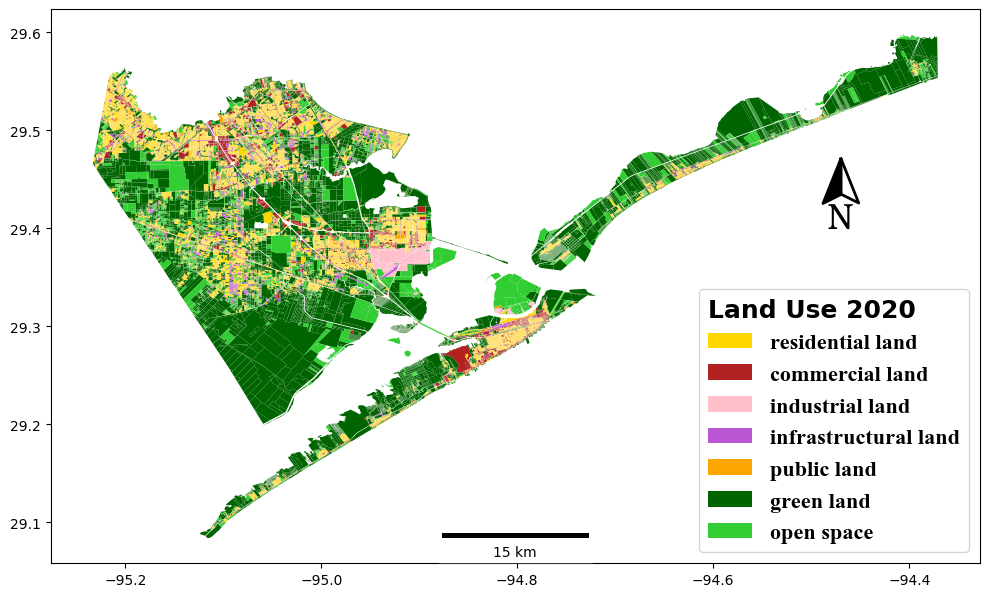

In [36]:
#fp = "../inputs/gis_data/Parcel_output_sce2.shp"
##Geodata = gpd.read_file(fp)
#read_start          = time.process_time()
#Geodata             = read_dataframe( fp )
#read_end            = time.process_time()
#Geodata      = Geodata.to_crs({'init':'epsg:4326'})

fig, ax = plt.subplots( figsize=(10, 8) )
pmarks = []
for ctype, data in Geodata.groupby('LUCode20re'):
    # Define the color for each group using the dictionary
    color = color_mapping[ctype]
    labeli = label_mapping[ctype]
    # Plot each group using the color defined above
    data.to_crs('EPSG:4326').plot(color=color, label= labeli ,
              ax = ax, linewidth=.01,
              markersize = 20, legend=True)
    #cx.add_basemap(plotx)
    pmarks.append(Patch(facecolor=color, label=labeli))

#ax.add_artist(scale2)
#ax.add_artist(ScaleBar(1, dimension="imperial-length", units="km"))
handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(prop={'family': 'Times New Roman', 'size' : 16, 'weight': 'bold'},
            handles=[ *handles,*pmarks ],
            title="",
            title_fontsize='xx-large', 
            loc='lower right',
            fontsize= 14,
            frameon=True )
leg._legend_box.align = "left"

legend = ax.get_legend()
legend.set_title( "Land Use 2020" , prop={'size' : 18, 'weight':'bold'})
x, y, arrow_length = 0.85, 0.65, 0.12
#ax.annotate('N', xy = (x,y), xytext = (x, y-arrow_length),
#                arrowprops = dict(facecolor='k', width=10, headwidth=30),
#                va = 'center', ha = 'center', fontsize = 40,
#                xycoords= ax.transAxes)
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist(
             ScaleBar( 100, dimension="si-length", 
             units="km", location="lower center", 
             length_fraction=0.2) )

#ax.set_title('', fontsize= 28)
ax.set_axis_on()
#src_basemap = cx.providers.Stamen.Terrain
#cx.add_basemap( ax, source=src_basemap)
#cx.add_basemap(ax)

plt.tight_layout()
#plt.savefig('../output_images/LandUse_test2_2.png',dpi= 900, bbox_inches='tight', pad_inches=0)
plt.savefig('../output_images/LandUse_2020_2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [43]:
Geodata.LUC20.value_counts()

LUC20
1    120027
6     25542
7     13764
2      6504
4      3175
5       993
3       189
Name: count, dtype: int64

In [44]:
Geodata.LUCode11re.value_counts()

LUCode11re
1    103635
7     28661
6     27808
2      6444
4      2697
5       805
3       144
Name: count, dtype: int64